In [ ]:
import pandas as pd
import numpy as np
import time
import joblib
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample


In [ ]:

data = pd.read_csv("all_data.csv")

# Lista cu top 20 caracteristici selectate
selected_features = [
    "Init_Win_bytes_backward", "Init_Win_bytes_forward", "min_seg_size_forward", "Fwd IAT Mean",
    "Average Packet Size", "Fwd Packet Length Max", "Flow IAT Mean", "Bwd Packets/s",
    "Flow IAT Std", "Subflow Fwd Bytes", "Bwd Packet Length Max", "Total Length of Fwd Packets",
    "Flow Duration", "Avg Fwd Segment Size", "Packet Length Mean", "Bwd Header Length",
    "Subflow Bwd Bytes", "Avg Bwd Segment Size", "Flow IAT Max", "Fwd IAT Total"
]


X = data[selected_features]
y = data["Label"]

# Grupare clase mici
y = y.replace({
    "Heartbleed": "Rare Events",
    "Infiltration": "Rare Events",
    "Web Attack - Brute Force": "Web Attack",
    "Web Attack - XSS": "Web Attack",
    "Web Attack - Sql Injection": "Web Attack"
})

#impartirea  setul de date
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Set de antrenament:", X_train.shape)
print("Set de validare:", X_val.shape)
print("Set de test:", X_test.shape)


C:\Users\William\AppData\Local\Temp\ipykernel_30576\795636908.py:2: DtypeWarning: Columns (84) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("all_data.csv")


Set de antrenament: (1981520, 20)
Set de validare: (424611, 20)
Set de test: (424612, 20)


In [ ]:

original_counts = y_train.value_counts()
print("\nDistribuția claselor înainte de SMOTE (setul de antrenament):")
print(original_counts)


moderate_classes = original_counts[(original_counts >= 1_000) & (original_counts < 100_000)].index
rare_classes = original_counts[original_counts < 1_000].index


smote = SMOTE(
    sampling_strategy={label: int(count * 1.5) for label, count in original_counts.items() if label in moderate_classes},
    random_state=42
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Oversampling pentru clasele rare
for label in rare_classes:
    # Selectam instantele din clasa respectiva
    class_data = X_train_smote[y_train_smote == label]
    class_labels = y_train_smote[y_train_smote == label]

    # Duplicam instantele de 3 ori
    oversampled_data = resample(
        class_data,
        replace=True,
        n_samples=len(class_data) * 3,
        random_state=42
    )
    oversampled_labels = [label] * len(oversampled_data)

    # Adaugam in setul de antrenament
    X_train_smote = pd.concat([pd.DataFrame(X_train_smote), pd.DataFrame(oversampled_data)])
    y_train_smote = pd.concat([pd.Series(y_train_smote), pd.Series(oversampled_labels)])

balanced_counts = Counter(y_train_smote)
print("\nDistribuția claselor după SMOTE ajustat:")
for label, count in balanced_counts.items():
    print(f"{label}: {count}")



Distribuția claselor înainte de SMOTE (setul de antrenament):
Label
BENIGN              1651502
DoS Hulk             161751
PortScan             111251
DDoS                  29285
DoS GoldenEye          7205
FTP-Patator            5557
SSH-Patator            4128
DoS slowloris          4057
DoS Slowhttptest       3849
Web Attack             1526
Bot                    1376
Rare Events              33
Name: count, dtype: int64

Distribuția claselor după SMOTE ajustat:
DoS Hulk: 161751
PortScan: 111251
BENIGN: 1651502
DDoS: 43927
Web Attack: 2289
SSH-Patator: 6192
DoS GoldenEye: 10807
DoS Slowhttptest: 5773
FTP-Patator: 8335
DoS slowloris: 6085
Bot: 2064
Rare Events: 132


In [ ]:

rf_base = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

# hiperparametri pentru GridSearch
param_grid = {
    'n_estimators': [300, 500, 1000],  
    'max_depth': [20, 30, None],  
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]  
}

# Folosim StratifiedKFold cu 3 fold-uri pentru Cross-Validation
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


grid_search = GridSearchCV(
    
   
     rf_base, param_grid, cv=cv_strategy, scoring="f1_weighted", n_jobs=1, verbose=3

    
)


start_time = time.time()
grid_search.fit(X_train_smote, y_train_smote)
print("\nGridSearch completat în %.2f secunde!" % (time.time() - start_time))

print("\nCei mai buni hiperparametri:", grid_search.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.975 total time= 4.1min
[CV 2/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.975 total time= 4.1min
[CV 3/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.975 total time= 4.0min
[CV 1/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.975 total time= 6.7min
[CV 2/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.975 total time= 6.8min
[CV 3/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.975 total time= 6.6min
[CV 1/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.975 total time=13.3min
[CV 2/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.975 total time=

In [ ]:



best_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

rf_optimized = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
# Antrenare modelul optimizat
#rf_optimized.fit(X_train_, y_train_resampled)
rf_optimized.fit(X_train_smote, y_train_smote)
print("Model Random Forest optimizat antrenat cu succes!")


Model Random Forest optimizat antrenat cu succes!


In [ ]:
# Facem predictii pe setul de test
y_test_pred = rf_optimized.predict(X_test)
joblib.dump(rf_optimized, "random_forest_model.pkl")


# Afișăm metricele de performanță
print("\nMatricea de confuzie:")
print(confusion_matrix(y_test, y_test_pred))

print("\nRaport de clasificare:")
print(classification_report(y_test, y_test_pred))



Matricea de confuzie:
[[351509     67   2014     13     76     45      1      2    165      0
       0      2]
 [    51    244      0      0      0      0      0      0      0      0
       0      0]
 [  2560      0   3711      0      4      0      0      0      0      0
       0      0]
 [     3      0      0   1540      1      0      0      0      0      0
       0      0]
 [    26      0      1      1  34633      0      0      0      0      0
       0      0]
 [    24      0      0      1      0    798      2      0      0      0
       0      0]
 [     3      0      0      0      0      2    863      0      0      0
       0      1]
 [     1      0      0      0      0      0      0   1190      0      0
       0      0]
 [     4      0      0      0      6      0      0      0  23830      0
       0      0]
 [     5      0      0      0      0      0      0      0      0      2
       0      0]
 [     3      0      0      0      0      0      0      0      0      0
     881      0

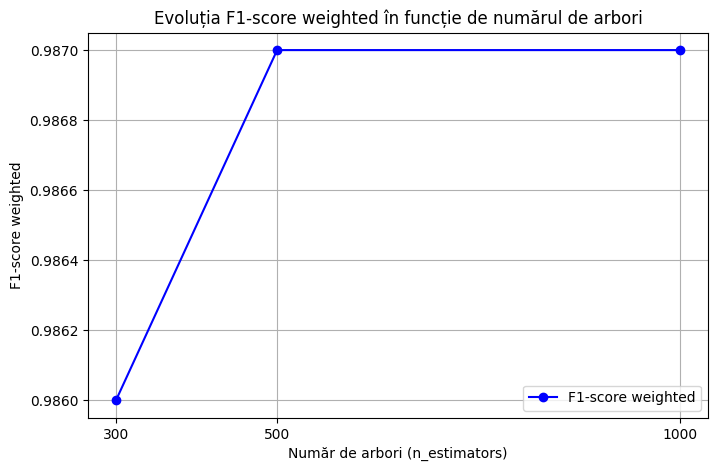

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Extragem valorile pentru n_estimators și F1-score din GridSearchCV
n_estimators_range = [300, 500, 1000]
f1_scores_weighted = [0.986, 0.987, 0.987]  # Extrase din rezultatele GridSearch

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, f1_scores_weighted, marker='o', linestyle='-', color='b', label="F1-score weighted")
plt.xlabel("Număr de arbori (n_estimators)")
plt.ylabel("F1-score weighted")
plt.title("Evoluția F1-score weighted în funcție de numărul de arbori")
plt.xticks(n_estimators_range)
plt.legend()
plt.grid(True)
plt.show()


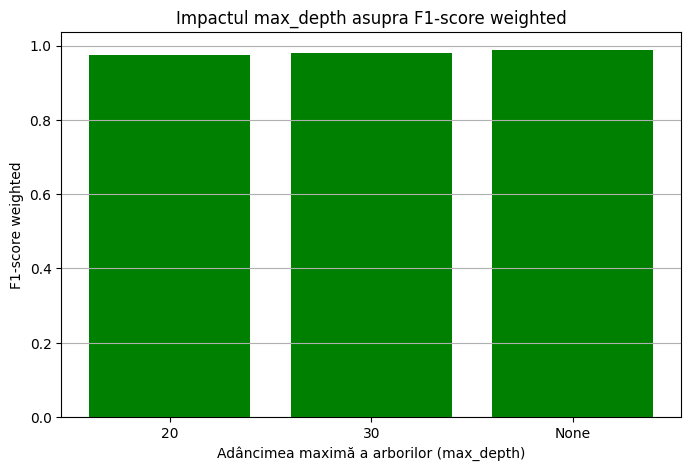

In [2]:
# Extragem valorile pentru max_depth și F1-score din GridSearchCV
max_depth_range = [20, 30, None]
f1_scores_depth = [0.975, 0.979, 0.987]  # Extrase din rezultatele GridSearch

plt.figure(figsize=(8, 5))
plt.bar([str(d) for d in max_depth_range], f1_scores_depth, color='g')
plt.xlabel("Adâncimea maximă a arborilor (max_depth)")
plt.ylabel("F1-score weighted")
plt.title("Impactul max_depth asupra F1-score weighted")
plt.grid(axis='y')
plt.show()


In [8]:
import pandas as pd

# Crearea DataFrame-ului extins
data_extended = {
    "Clasă": ["BENIGN", "Bot", "DDoS", "DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", 
              "DoS slowloris", "FTP-Patator", "PortScan", "Rare Events", "SSH-Patator", "Web Attack",
              "Accuracy", "Macro Avg", "Weighted Avg"],
    "Precizie": [0.99, 0.78, 0.65, 0.99, 1.00, 0.94, 1.00, 1.00, 0.99, 1.00, 1.00, 0.99, 
                 None, 0.94, 0.99],
    "Recall": [0.99, 0.83, 0.59, 1.00, 1.00, 0.97, 0.99, 1.00, 1.00, 0.29, 1.00, 0.95, 
               0.99, 0.88, 0.99],
    "F1-Score": [0.99, 0.81, 0.62, 0.99, 1.00, 0.96, 0.99, 1.00, 1.00, 0.44, 1.00, 0.97, 
                 None, 0.90, 0.99],
    "Număr probe (support)": [353894, 295, 6275, 1544, 34661, 825, 869, 1191, 23840, 7, 884, 327,
                              424612, 424612, 424612]
}

df_extended = pd.DataFrame(data_extended)

# Afișare tabel
print(df_extended)


               Clasă  Precizie  Recall  F1-Score  Număr probe (support)
0             BENIGN      0.99    0.99      0.99                 353894
1                Bot      0.78    0.83      0.81                    295
2               DDoS      0.65    0.59      0.62                   6275
3      DoS GoldenEye      0.99    1.00      0.99                   1544
4           DoS Hulk      1.00    1.00      1.00                  34661
5   DoS Slowhttptest      0.94    0.97      0.96                    825
6      DoS slowloris      1.00    0.99      0.99                    869
7        FTP-Patator      1.00    1.00      1.00                   1191
8           PortScan      0.99    1.00      1.00                  23840
9        Rare Events      1.00    0.29      0.44                      7
10       SSH-Patator      1.00    1.00      1.00                    884
11        Web Attack      0.99    0.95      0.97                    327
12          Accuracy       NaN    0.99       NaN                

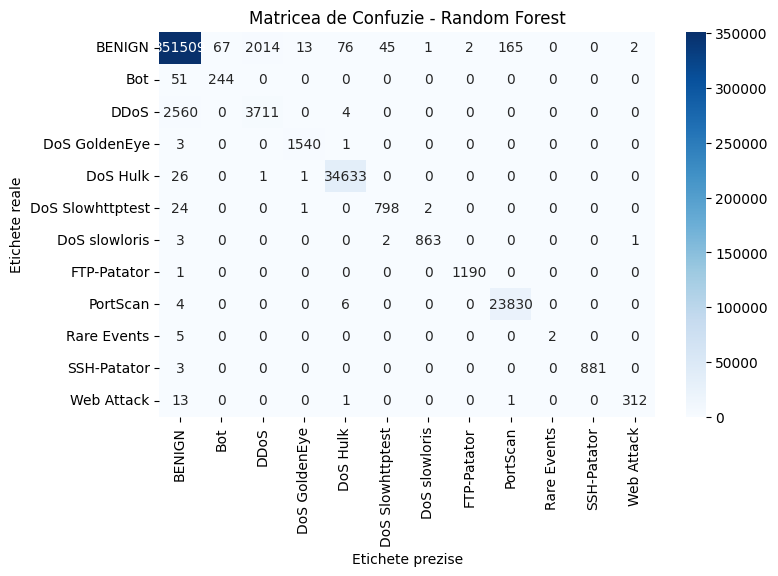

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Definirea matricei de confuzie
conf_matrix = np.array([[351509, 67, 2014, 13, 76, 45, 1, 2, 165, 0, 0, 2],
                        [51, 244, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [2560, 0, 3711, 0, 4, 0, 0, 0, 0, 0, 0, 0],
                        [3, 0, 0, 1540, 1, 0, 0, 0, 0, 0, 0, 0],
                        [26, 0, 1, 1, 34633, 0, 0, 0, 0, 0, 0, 0],
                        [24, 0, 0, 1, 0, 798, 2, 0, 0, 0, 0, 0],
                        [3, 0, 0, 0, 0, 2, 863, 0, 0, 0, 0, 1],
                        [1, 0, 0, 0, 0, 0, 0, 1190, 0, 0, 0, 0],
                        [4, 0, 0, 0, 6, 0, 0, 0, 23830, 0, 0, 0],
                        [5, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
                        [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 881, 0],
                        [13, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 312]])

# Definirea etichetelor claselor
class_labels = ["BENIGN", "Bot", "DDoS", "DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest",
                "DoS slowloris", "FTP-Patator", "PortScan", "Rare Events", "SSH-Patator", "Web Attack"]

# Crearea graficului pentru matricea de confuzie
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Etichete prezise")
plt.ylabel("Etichete reale")
plt.title("Matricea de Confuzie - Random Forest")

# Afișarea graficului
plt.show()
